# Breast Cancer Data - Exploration 

This dataset contains gene expression data for **TCGA** (The Cancer Genome Atlas) breast cancer patients.
Such raw counts were obtained using the reference genome **GRCH38**. The TCGA BRCA project contains 1097 gene expression profiles, while in our dataset there is only 1053 samples whose PAM%) sbutypes were already available.

The dataset is structured in the following way:

* Patients are on the rows, and 25150 protein coding genes are on the columns 
* The first column includes the TCGA ID of each patient
* The second column contains the PAM50 subtype of each patient, as publicly available on the metadata of the TCGA BRCA project 



In [4]:
import pandas as pd
import os
import seaborn as sns
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt

# Set parameters
plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 10

## Table Form Visualization

In [5]:
DATASET_PATH = "tcga_brca_raw_19036_1053samples.pkl"

with open(DATASET_PATH, 'rb') as file:
    dataset = pkl.load(file) 

dataset.head()

,tcga_id,expert_PAM50_subtype,sample_id,cancer_type,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,TCGA-3C-AAAU,LumA,1CBCD09F-2824-4E99-B657-F9565E9C9372,Breast Invasive Carcinoma,57898,67829,134,1697402,44314,1737,...,127715,285105,80532,272148,283023,84420,356353,1054121,557596,409660
1,TCGA-3C-AALI,Her2,58FB7633-DF82-406F-B4CB-277BE8DE003D,Breast Invasive Carcinoma,52146,65152,1361,1403901,36852,1636,...,225863,188283,24306,79305,219241,42889,112979,1041074,247545,88163
2,TCGA-3C-AALJ,LumB,F7B0D141-4D33-4A6E-8E05-08F7CF325459,Breast Invasive Carcinoma,52172,29356,510,989281,30378,282,...,36095,292971,9799,56118,48681,40923,63021,613785,110466,68745
3,TCGA-3C-AALK,LumA,22CB86F1-88B4-405A-B20F-A29694950367,Breast Invasive Carcinoma,50517,43436,287,2674831,69374,816,...,99575,169487,27979,99448,126525,48154,150177,1397623,196615,206477
4,TCGA-4H-AAAK,LumA,71F8A28D-077A-4A91-B56E-B035E4861E9C,Breast Invasive Carcinoma,66433,66229,192,2279532,56667,1603,...,99144,171558,23633,95460,118564,4928,188499,970767,199472,246179


In [6]:
print('Number of samples: ', dataset.shape[0])
print('Number of genes: ', dataset.shape[1] - 4) # first 4 columns dont represent genes
print('PAM50 sybtypes: ', dataset.expert_PAM50_subtype.unique())
print('Cancer types: ', dataset.cancer_type.unique())

Number of samples:  1053
Number of genes:  25150
PAM50 sybtypes:  ['LumA' 'Her2' 'LumB' 'Basal' 'Normal']
Cancer types:  ['Breast Invasive Carcinoma']


## Class Imbalance Issue

From the previous plot it is obvious that in our dataset classes are not balanced. In order to solve or reduce this problem there are several approached we can use:

* Using other metrics except accuracy, i.e. F1-score, precision, recall, and confusion matrices
* Resampling (over- and under- sampling)
* Generating new samples with SMOTE or Tomek links

Number of samples per class:
LumA      546
LumB      208
Basal     179
Her2       81
Normal     39
Name: expert_PAM50_subtype, dtype: int64


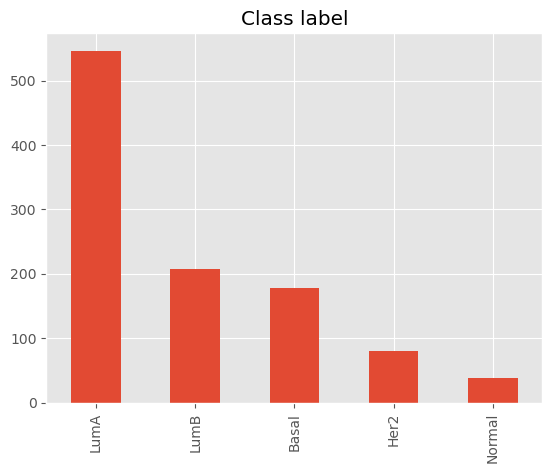

In [7]:
# Check the class balanse status of a dataset
y = dataset.expert_PAM50_subtype
ax = y.value_counts().plot(kind='bar', title='Class label')

print('Number of samples per class:')
print(y.value_counts())


## Gene correlation

In [8]:
genes_data = dataset.drop(columns=['tcga_id','expert_PAM50_subtype','sample_id','cancer_type'], inplace=False)

<AxesSubplot: >

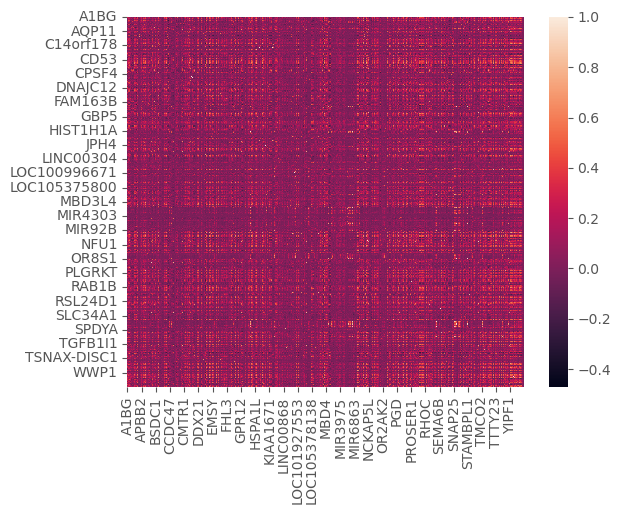

In [5]:
corr_matrix = genes_data.corr().abs()

sns.heatmap(corr_matrix)

Steps:

1. Load the dataset and do the train|test split 
2. Improve the imbalance situation
3. Standardization of the train set only
4. Define the model 
5. Define the feature selection technique:
    * SULOV 
    * Recursive XGBoost
6. Add grid search to find a better solution
7. Test on the test set

## Clustering approaches

* K-means
* Density-based Spatial Clustering (DBSCAN)
* Hierarchical agglomerative Clustering

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(genes_data, y, test_size=0.3, random_state=1, 
                                                    shuffle=True, stratify=y)     
# Standardize 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
 

### K-Means

In [17]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# K-means
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto")

kmeans.fit(X_train_scaled)
labels_assigned = kmeans.labels_
labels = kmeans.get_feature_names_out()

clusters = kmeans.predict(X_test)
cluster_coords = kmeans.cluster_centers_

/Users/ivamilojkovic/opt/anaconda3/envs/bca_env/lib/python3.9/site-packages/sklearn/base.py:402: UserWarning:

X has feature names, but KMeans was fitted without feature names



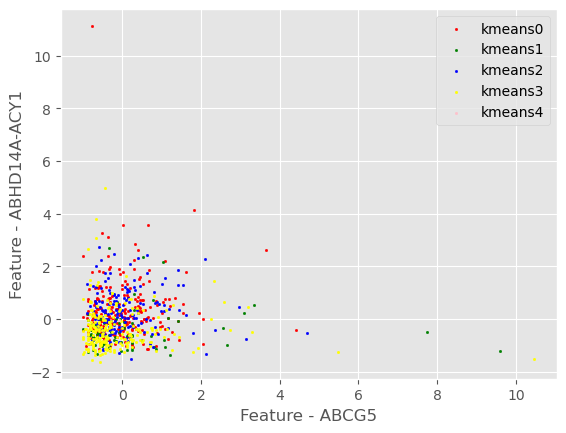

In [12]:
# Let's try to visualize the clusters from different planes
def plot_clusters(gene_data, y, feat_idx_1, feat_idx_2, labels):

    feature_names = gene_data.columns
    label_colors = ['red', 'green', 'blue', 'yellow', 'pink']

    # Plot by labels
    for i, label in enumerate(labels):
        plt.scatter(gene_data.iloc[:,feat_idx_1][labels_assigned==i], 
                    gene_data.iloc[:,feat_idx_2][labels_assigned==i],
                    marker = '.', c = label_colors[i], s=10)
    
    plt.xlabel("Feature - " + feature_names[feat_idx_1])
    plt.ylabel("Feature - " + feature_names[feat_idx_2])
    plt.legend(labels)

plot_clusters(X_train, clusters, 90, 100, labels)

### DBSCAN 

DBSCAN is a density-based clustering non-parametric algorithm. Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away - noise points). 

DBSCAN requires two parameters: **ε (eps)** and the **minimum number of points** required to form a dense region. It starts with an arbitrary starting point that has not been visited. This point's ε-neighborhood is retrieved, and if it contains sufficiently many points, a cluster is started. Otherwise, the point is labeled as noise. Note that this point might later be found in a sufficiently sized ε-environment of a different point and hence be made part of a cluster.

If a point is found to be a dense part of a cluster, its ε-neighborhood is also part of that cluster. Hence, all points that are found within the ε-neighborhood are added, as is their own ε-neighborhood when they are also dense. This process continues until the density-connected cluster is completely found. Then, a new unvisited point is retrieved and processed, leading to the discovery of a further cluster or noise.

DBSCAN can be used with any distance function!

In [23]:
dbscan = DBSCAN(eps=0.001,min_samples=100)
dbscan.fit(X_train_scaled)
db_labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


Estimated number of clusters: 0
Estimated number of noise points: 737


### Agglomerative Clustering

In [32]:
import numpy as np

agg_cluster = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
agg_cluster.fit(X_train_scaled)
labels = np.unique(agg_cluster.labels_)

# Number of clusters in labels, ignoring noise if present.
n_per_cluster = [list(agg_cluster.labels_).count(i) for i in range(5)]

print("Number of labels per cluster: ", n_per_cluster)

Number of labels per cluster:  [294, 66, 4, 303, 70]


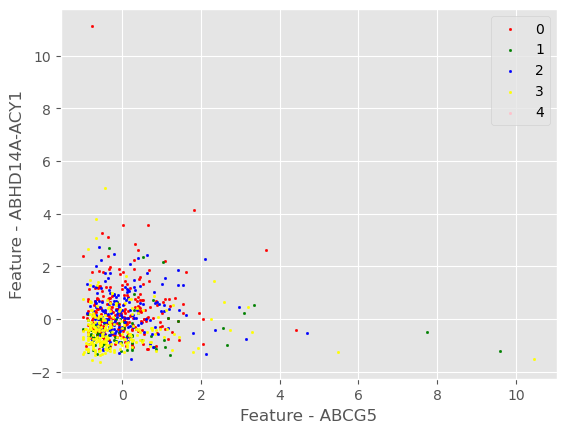

In [33]:
plot_clusters(X_train, labels_assigned, 90, 100, labels)

### Visualizing High Dimensional Clusters

* Principal Component Analysis (PCA)

    PCA is an algorithm that is used for dimensionality reduction - meaning, informally, that it can take in a DataFrame with many columns and return a DataFrame with a reduced number of columns that still retains much of the information from the columns of the original DataFrame. The columns of the DataFrame produced from the PCA procedure are called Principal Components. We will use these principal components to help us visualize our clusters in 1-D, 2-D, and 3-D space, since we cannot easily visualize the data we have in higher dimensions. For example, we can use two principal components to visualize the clusters in 2-D space, or three principal components to visualize the clusters in 3-D space.
    
* T-Distributed Stochastic Neighbor Embedding (T-SNE)


In [14]:
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [35]:
# Let's try to visualize the clusters from different planes
def plot_pca(df_pca_2, labels, dim=2):

    label_colors = ['red', 'green', 'blue', 'yellow', 'pink']

    if dim==2:
        for i, label in enumerate(labels):
            plt.scatter(df_pca_2.iloc[:,0][labels_assigned==i], 
                        df_pca_2.iloc[:,1][labels_assigned==i],
                        marker = '.', c = label_colors[i], s=10)
        
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")

    if dim==3:

        # Creating figure
        fig = plt.figure()
        ax = plt.axes(projection ="3d")

        for i, label in enumerate(labels):
            ax.scatter3D(df_pca_2.iloc[:,0][labels_assigned==i], 
                        df_pca_2.iloc[:,1][labels_assigned==i],
                        df_pca_2.iloc[:,2][labels_assigned==i],
                        marker = '.', c = label_colors[i])
        
        ax.set_xlabel("PCA component 1")
        ax.set_ylabel("PCA component 2")
        ax.set_zlabel("PCA component 2")

    plt.legend(labels)

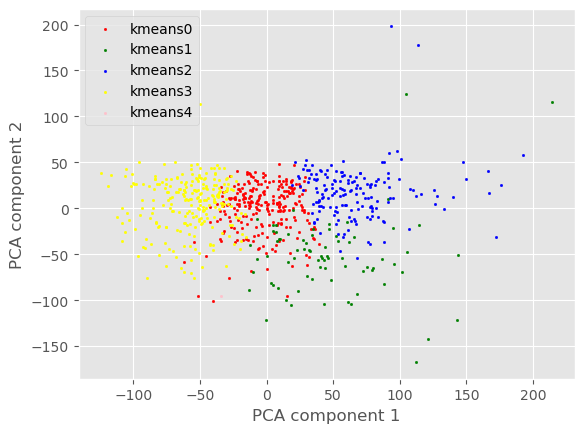

In [36]:
pca_2 = PCA(n_components=2)
df_pca_2 = pd.DataFrame(pca_2.fit_transform(X_train_scaled), columns=['PCA_1', 'PCA_2'])

plot_pca(df_pca_2, labels)

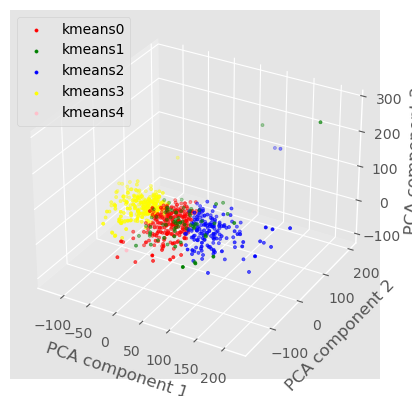

In [37]:
pca_3 = PCA(n_components=3)
df_pca_3 = pd.DataFrame(pca_3.fit_transform(X_train_scaled), columns=['PCA_1', 'PCA_2', 'PCA_3'])

plot_pca(df_pca_3, labels, dim=3)

## Embeddings

Since it is really difficult to understand and intepret clusters in dimensional spaces when having more than 3 feature. For that reason, it would be useful to represent genes (in our case vectors) as vectors i.e. embeddings. Having these vectors we can also include the relationship with other genes. Firstly, we hypothesized that gene properties (samples in our case) are also distributional, such that *character of a gene can be defined by its companies* in term of gene expression, and embedding can be employed to infer the relationship between genes, therefore, relevant biological information could be retrieved from embedding space.